In [1]:
import numpy as np
import pandas as pd
import torch
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

import pickle


%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from datasets import DatasetDict
from datasets import load_dataset, load_metric, concatenate_datasets

from hw3 import training


from cs236781.plot import plot_fit
from cs236781.train_results import FitResult

$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 4: Fine-Tuning a pretrained language model
<a id=part3></a>

In this part , we will deal with the fine-tuning of BERT for sentiment analysis on the IMDB movie reivews dataset from the previous section.   
BERT is a large language model developed by Google researchers in 2019 that offers a good balance between popularity and model size, which can be fine-tuned using a simple GPU.  

If you aren't yet familiar, you can check it out here:  
https://arxiv.org/pdf/1810.04805.pdf.
(Read Section 3 for details on the model architecture and fine-tuning on downstream tasks).

In particular, we will use the distilled (smaller) version of BERT, called Distil-BERT.
Distil-BERT is widely used in production since it has 40% fewer parameters than BERT, while running 60% faster and retaining 95% of the performance in many benchmarks.
It is recommended to glance through the Distil-BERT paper to get a feel for the model architecture and how it differs from BERT: 
https://arxiv.org/pdf/1910.01108.pdf

We will download a pre-trained `Distil-BERT` from `Hugging Face`, so there is no need to train it from scratch. 

One of the key strengths of Hugging Face is its extensive collection of pre-trained models. These models are trained on large-scale datasets and exhibit impressive performance on various NLP tasks, such as text classification, named entity recognition, sentiment analysis, machine translation, and question answering, among others. The pre-trained models provided by Hugging Face can be easily fine-tuned for specific downstream tasks, saving significant time and computational resources.  


## Loading the Dataset

We will now load and prepare the IMDB dataset as we did in the previous part.  
Here we will load the full training and test set.


In [3]:
dataset = load_dataset('imdb', split=['train', 'test[12260:12740]'])

In [4]:
print(dataset)

[Dataset({
    features: ['text', 'label'],
    num_rows: 25000
}), Dataset({
    features: ['text', 'label'],
    num_rows: 480
})]


In [5]:
#wrap it in a DatasetDict to enable methods such as map and format
dataset = DatasetDict({'train': dataset[0], 'test': dataset[1]})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
})

We can now access the datasets in the Dict as we would a dictionary.
Let's print a few training samples

In [7]:
for i in range(4):
    print(f'TRAINING SAMPLE {i}:') 
    print(dataset['train'][i]['text'])
    label = dataset['train'][i]['label']
    print(f'Label {i}: {label}')
    print('\n')

TRAINING SAMPLE 0:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We should also check the label distribution:

In [8]:
def label_cnt(type):
    ds = dataset[type]
    size = len(ds)
    cnt= 0 
    for smp in ds:
        cnt += smp['label']
    print(f'negative samples in {type} dataset: {size - cnt}')
    print(f'positive samples in {type} dataset: {cnt}')
    
label_cnt('train')
label_cnt('test')

negative samples in train dataset: 12500
positive samples in train dataset: 12500
negative samples in test dataset: 240
positive samples in test dataset: 240


### __Import the tokenizer for the dataset__


We will now tokenize the text the same way we did in the previous part.



In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


/home/nativ/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

def tokenize_dataset(dataset):
    dataset_tokenized = dataset.map(tokenize_text, batched=True, batch_size =None)
    return dataset_tokenized

dataset_tokenized = tokenize_dataset(dataset)
# we would like to work with pytorch so we can manually fine-tune
dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# no need to parrarelize in this assignment
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Setting up the dataloaders and dataset

We will now set up the dataloaders for efficient batching and loading of the data.  
By now, you are familiar with the Class methods that are needed to create a working Dataloader.


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.ds = dataset

    def __getitem__(self, index):
        return self.ds[index]

    def __len__(self):
        return self.ds.num_rows

In [12]:
train_dataset = IMDBDataset(dataset_tokenized['train'])
test_dataset = IMDBDataset(dataset_tokenized['test'])

In [13]:

n_workers= 0

dl_train,dl_test = [ 
    DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True, 
    num_workers=n_workers
),
DataLoader(
    dataset=test_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=n_workers
)]

In [14]:
dl_train

## Importing the model from Hugging Face
We will now  delve into the process of loading the DistilBERT model from `Hugging Face`. DistilBERT is a distilled version of the BERT model, offering a lighter and faster alternative while retaining considerable performance on various NLP tasks.  
Please refer to the introduction to check out the relevant papers.  
For more info on how to use this model, feel free to check it out on the site:  
https://huggingface.co/distilbert-base-uncased 



To begin, we will import the necessary library required for our implementation.
It is fine if you receive a warning from `Hugging Face` to train the model on a downstream task, which is exactly what we will do on our IMDB dataset. 

In [15]:
from transformers import AutoModelForSequenceClassification


In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


__Let's print the model architecture to see what we are dealing with:__

In [17]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Fine Tuning
We will now move on to the process of fine-tuning the model that we previously loaded from `Hugging Face`. Fine-tuning allows us to adapt the pre-trained model to our specific NLP task by further training it on task-specific data. This process enhances the model's performance and enables it to make more accurate predictions on our target task.  

There are generally two approaches to fine-tuning the loaded model, each with its own advantages and considerations:  

1) __Freeze all the weights besides the last two linear layers and train only those layers__:  
This approach is commonly referred to as "transfer learning" or "feature extraction." By freezing the weights of the majority of the model's layers, we retain the pre-trained knowledge captured by the model, allowing it to extract useful features from our data. We then replace and train the final few layers, typically linear layers, to adapt the model to our specific task. This method is beneficial when we have limited labeled data or when the pre-trained model has been trained on a similar domain.

2) __Retrain all the parameters in the model__:  
This approach involves unfreezing and training all the parameters of the loaded model, including the pre-trained layers. By retraining all the parameters, we allow the model to adjust its representations and update its knowledge based on our specific task and data. This method is often preferred when we have sufficient labeled data available and want the model to learn task-specific features from scratch or when the pre-trained model's knowledge may not be directly applicable to our domain.

### Fine-tuning method 1 
__Freeze all the weights besides the last two linear layers and train only those layers__



In [18]:
# TODO:
# Freeze all parameters except for the last 2 linear layers
# ====== YOUR CODE: ======
for name, param in model.named_parameters():
    if "weight" in name:
        param.requires_grad = False
    if (name == "distilbert.transformer.layer.5.ffn.lin1.weight") or (name == "distilbert.transformer.layer.5.ffn.lin2.weight"):
        param.requires_grad = True
# ========================

# HINT: use the printed model architecture to get the layer names




### Training 
We can use our abstract __Trainer__ class to fine-tune the model:
We will not play around with hyperparameters in this section, as the point is to learn to fine-tune a model.   
In addition, we do not need to send our own loss function for this loaded model (try to understand why).   

__TODO__: Implement the `FineTuningTrainer` in `hw3/training.py`

We will train the model for 2 epochs of 40 batches.  
You can run this either locally or on the course servers, whichever is most comfortable for you.

In [19]:
from hw3 import training

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_last_2.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_last_2', num_epochs=2, max_batches= 40)
    with open('fit_result_finetune_2.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_last_2.pt')
model.load_state_dict(saved_state['model_state']) 
best_acc = saved_state['best_acc']
print('best acc:', best_acc)

with open('fit_result_finetune_2.pkl', 'rb') as f:
    fit_result = pickle.load(f) 



--- EPOCH 1/2 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch (0.701):   0%|          | 0/40 [00:04<?, ?it/s]

train_batch (0.701):   2%|▎         | 1/40 [00:04<02:50,  4.37s/it]

train_batch (0.679):   2%|▎         | 1/40 [00:05<02:50,  4.37s/it]

train_batch (0.679):   5%|▌         | 2/40 [00:05<01:33,  2.47s/it]

train_batch (0.696):   5%|▌         | 2/40 [00:06<01:33,  2.47s/it]

train_batch (0.696):   8%|▊         | 3/40 [00:06<01:06,  1.81s/it]

train_batch (0.682):   8%|▊         | 3/40 [00:07<01:06,  1.81s/it]

train_batch (0.682):  10%|█         | 4/40 [00:07<00:53,  1.47s/it]

train_batch (0.693):  10%|█         | 4/40 [00:08<00:53,  1.47s/it]

train_batch (0.693):  12%|█▎        | 5/40 [00:08<00:44,  1.28s/it]

train_batch (0.682):  12%|█▎        | 5/40 [00:09<00:44,  1.28s/it]

train_batch (0.682):  15%|█▌        | 6/40 [00:09<00:40,  1.19s/it]

train_batch (0.632):  15%|█▌        | 6/40 [00:10<00:40,  1.19s/it]

train_batch (0.632):  18%|█▊        | 7/40 [00:10<00:37,  1.12s/it]

train_batch (0.678):  18%|█▊        | 7/40 [00:11<00:37,  1.12s/it]

train_batch (0.678):  20%|██        | 8/40 [00:11<00:35,  1.10s/it]

train_batch (0.688):  20%|██        | 8/40 [00:12<00:35,  1.10s/it]

train_batch (0.688):  22%|██▎       | 9/40 [00:12<00:33,  1.07s/it]

train_batch (0.736):  22%|██▎       | 9/40 [00:13<00:33,  1.07s/it]

train_batch (0.736):  25%|██▌       | 10/40 [00:13<00:31,  1.04s/it]

train_batch (0.727):  25%|██▌       | 10/40 [00:14<00:31,  1.04s/it]

train_batch (0.727):  28%|██▊       | 11/40 [00:14<00:30,  1.04s/it]

train_batch (0.796):  28%|██▊       | 11/40 [00:15<00:30,  1.04s/it]

train_batch (0.796):  30%|███       | 12/40 [00:15<00:29,  1.04s/it]

train_batch (0.757):  30%|███       | 12/40 [00:16<00:29,  1.04s/it]

train_batch (0.757):  32%|███▎      | 13/40 [00:16<00:28,  1.05s/it]

train_batch (0.695):  32%|███▎      | 13/40 [00:17<00:28,  1.05s/it]

train_batch (0.695):  35%|███▌      | 14/40 [00:17<00:26,  1.03s/it]

train_batch (0.736):  35%|███▌      | 14/40 [00:18<00:26,  1.03s/it]

train_batch (0.736):  38%|███▊      | 15/40 [00:18<00:25,  1.01s/it]

train_batch (0.657):  38%|███▊      | 15/40 [00:19<00:25,  1.01s/it]

train_batch (0.657):  40%|████      | 16/40 [00:19<00:24,  1.01s/it]

train_batch (0.700):  40%|████      | 16/40 [00:20<00:24,  1.01s/it]

train_batch (0.700):  42%|████▎     | 17/40 [00:20<00:23,  1.02s/it]

train_batch (0.699):  42%|████▎     | 17/40 [00:21<00:23,  1.02s/it]

train_batch (0.699):  45%|████▌     | 18/40 [00:21<00:22,  1.00s/it]

train_batch (0.678):  45%|████▌     | 18/40 [00:22<00:22,  1.00s/it]

train_batch (0.678):  48%|████▊     | 19/40 [00:22<00:20,  1.00it/s]

train_batch (0.672):  48%|████▊     | 19/40 [00:23<00:20,  1.00it/s]

train_batch (0.672):  50%|█████     | 20/40 [00:23<00:19,  1.00it/s]

train_batch (0.668):  50%|█████     | 20/40 [00:24<00:19,  1.00it/s]

train_batch (0.668):  52%|█████▎    | 21/40 [00:24<00:19,  1.00s/it]

train_batch (0.684):  52%|█████▎    | 21/40 [00:25<00:19,  1.00s/it]

train_batch (0.684):  55%|█████▌    | 22/40 [00:25<00:18,  1.02s/it]

train_batch (0.683):  55%|█████▌    | 22/40 [00:26<00:18,  1.02s/it]

train_batch (0.683):  57%|█████▊    | 23/40 [00:26<00:17,  1.02s/it]

train_batch (0.683):  57%|█████▊    | 23/40 [00:27<00:17,  1.02s/it]

train_batch (0.683):  60%|██████    | 24/40 [00:27<00:16,  1.02s/it]

train_batch (0.685):  60%|██████    | 24/40 [00:28<00:16,  1.02s/it]

train_batch (0.685):  62%|██████▎   | 25/40 [00:28<00:15,  1.02s/it]

train_batch (0.686):  62%|██████▎   | 25/40 [00:29<00:15,  1.02s/it]

train_batch (0.686):  65%|██████▌   | 26/40 [00:29<00:14,  1.01s/it]

train_batch (0.670):  65%|██████▌   | 26/40 [00:30<00:14,  1.01s/it]

train_batch (0.670):  68%|██████▊   | 27/40 [00:30<00:12,  1.01it/s]

train_batch (0.681):  68%|██████▊   | 27/40 [00:31<00:12,  1.01it/s]

train_batch (0.681):  70%|███████   | 28/40 [00:31<00:11,  1.01it/s]

train_batch (0.717):  70%|███████   | 28/40 [00:32<00:11,  1.01it/s]

train_batch (0.717):  72%|███████▎  | 29/40 [00:32<00:11,  1.00s/it]

train_batch (0.679):  72%|███████▎  | 29/40 [00:33<00:11,  1.00s/it]

train_batch (0.679):  75%|███████▌  | 30/40 [00:33<00:10,  1.01s/it]

train_batch (0.697):  75%|███████▌  | 30/40 [00:34<00:10,  1.01s/it]

train_batch (0.697):  78%|███████▊  | 31/40 [00:34<00:09,  1.02s/it]

train_batch (0.685):  78%|███████▊  | 31/40 [00:35<00:09,  1.02s/it]

train_batch (0.685):  80%|████████  | 32/40 [00:35<00:08,  1.02s/it]

train_batch (0.678):  80%|████████  | 32/40 [00:36<00:08,  1.02s/it]

train_batch (0.678):  82%|████████▎ | 33/40 [00:36<00:07,  1.02s/it]

train_batch (0.670):  82%|████████▎ | 33/40 [00:37<00:07,  1.02s/it]

train_batch (0.670):  85%|████████▌ | 34/40 [00:37<00:06,  1.02s/it]

train_batch (0.699):  85%|████████▌ | 34/40 [00:38<00:06,  1.02s/it]

train_batch (0.699):  88%|████████▊ | 35/40 [00:38<00:05,  1.03s/it]

train_batch (0.688):  88%|████████▊ | 35/40 [00:39<00:05,  1.03s/it]

train_batch (0.688):  90%|█████████ | 36/40 [00:39<00:04,  1.03s/it]

train_batch (0.680):  90%|█████████ | 36/40 [00:40<00:04,  1.03s/it]

train_batch (0.680):  92%|█████████▎| 37/40 [00:40<00:03,  1.02s/it]

train_batch (0.668):  92%|█████████▎| 37/40 [00:41<00:03,  1.02s/it]

train_batch (0.668):  95%|█████████▌| 38/40 [00:41<00:02,  1.00s/it]

train_batch (0.705):  95%|█████████▌| 38/40 [00:42<00:02,  1.00s/it]

train_batch (0.705):  98%|█████████▊| 39/40 [00:42<00:01,  1.01s/it]

train_batch (0.674):  98%|█████████▊| 39/40 [00:43<00:01,  1.01s/it]

train_batch (0.674): 100%|██████████| 40/40 [00:43<00:00,  1.02s/it]

train_batch (Avg. Loss 0.692, Accuracy 54.2): 100%|██████████| 40/40 [00:43<00:00,  1.02s/it]

train_batch (Avg. Loss 0.692, Accuracy 54.2): 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.671):   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.671):   2%|▎         | 1/40 [00:00<00:14,  2.76it/s]

test_batch (0.635):   2%|▎         | 1/40 [00:00<00:14,  2.76it/s]

test_batch (0.635):   5%|▌         | 2/40 [00:00<00:15,  2.53it/s]

test_batch (0.663):   5%|▌         | 2/40 [00:01<00:15,  2.53it/s]

test_batch (0.663):   8%|▊         | 3/40 [00:01<00:14,  2.51it/s]

test_batch (0.650):   8%|▊         | 3/40 [00:01<00:14,  2.51it/s]

test_batch (0.650):  10%|█         | 4/40 [00:01<00:14,  2.50it/s]

test_batch (0.660):  10%|█         | 4/40 [00:01<00:14,  2.50it/s]

test_batch (0.660):  12%|█▎        | 5/40 [00:01<00:14,  2.49it/s]

test_batch (0.650):  12%|█▎        | 5/40 [00:02<00:14,  2.49it/s]

test_batch (0.650):  15%|█▌        | 6/40 [00:02<00:13,  2.49it/s]

test_batch (0.655):  15%|█▌        | 6/40 [00:02<00:13,  2.49it/s]

test_batch (0.655):  18%|█▊        | 7/40 [00:02<00:13,  2.48it/s]

test_batch (0.649):  18%|█▊        | 7/40 [00:03<00:13,  2.48it/s]

test_batch (0.649):  20%|██        | 8/40 [00:03<00:12,  2.49it/s]

test_batch (0.679):  20%|██        | 8/40 [00:03<00:12,  2.49it/s]

test_batch (0.679):  22%|██▎       | 9/40 [00:03<00:12,  2.49it/s]

test_batch (0.651):  22%|██▎       | 9/40 [00:03<00:12,  2.49it/s]

test_batch (0.651):  25%|██▌       | 10/40 [00:03<00:12,  2.50it/s]

test_batch (0.636):  25%|██▌       | 10/40 [00:04<00:12,  2.50it/s]

test_batch (0.636):  28%|██▊       | 11/40 [00:04<00:11,  2.50it/s]

test_batch (0.637):  28%|██▊       | 11/40 [00:04<00:11,  2.50it/s]

test_batch (0.637):  30%|███       | 12/40 [00:04<00:11,  2.50it/s]

test_batch (0.642):  30%|███       | 12/40 [00:05<00:11,  2.50it/s]

test_batch (0.642):  32%|███▎      | 13/40 [00:05<00:10,  2.50it/s]

test_batch (0.676):  32%|███▎      | 13/40 [00:05<00:10,  2.50it/s]

test_batch (0.676):  35%|███▌      | 14/40 [00:05<00:10,  2.49it/s]

test_batch (0.678):  35%|███▌      | 14/40 [00:06<00:10,  2.49it/s]

test_batch (0.678):  38%|███▊      | 15/40 [00:06<00:10,  2.49it/s]

test_batch (0.653):  38%|███▊      | 15/40 [00:06<00:10,  2.49it/s]

test_batch (0.653):  40%|████      | 16/40 [00:06<00:09,  2.48it/s]

test_batch (0.660):  40%|████      | 16/40 [00:06<00:09,  2.48it/s]

test_batch (0.660):  42%|████▎     | 17/40 [00:06<00:09,  2.49it/s]

test_batch (0.651):  42%|████▎     | 17/40 [00:07<00:09,  2.49it/s]

test_batch (0.651):  45%|████▌     | 18/40 [00:07<00:08,  2.48it/s]

test_batch (0.640):  45%|████▌     | 18/40 [00:07<00:08,  2.48it/s]

test_batch (0.640):  48%|████▊     | 19/40 [00:07<00:08,  2.49it/s]

test_batch (0.654):  48%|████▊     | 19/40 [00:08<00:08,  2.49it/s]

test_batch (0.654):  50%|█████     | 20/40 [00:08<00:08,  2.48it/s]

test_batch (0.691):  50%|█████     | 20/40 [00:08<00:08,  2.48it/s]

test_batch (0.691):  52%|█████▎    | 21/40 [00:08<00:07,  2.49it/s]

test_batch (0.689):  52%|█████▎    | 21/40 [00:08<00:07,  2.49it/s]

test_batch (0.689):  55%|█████▌    | 22/40 [00:08<00:07,  2.49it/s]

test_batch (0.691):  55%|█████▌    | 22/40 [00:09<00:07,  2.49it/s]

test_batch (0.691):  57%|█████▊    | 23/40 [00:09<00:06,  2.50it/s]

test_batch (0.701):  57%|█████▊    | 23/40 [00:09<00:06,  2.50it/s]

test_batch (0.701):  60%|██████    | 24/40 [00:09<00:06,  2.48it/s]

test_batch (0.673):  60%|██████    | 24/40 [00:10<00:06,  2.48it/s]

test_batch (0.673):  62%|██████▎   | 25/40 [00:10<00:06,  2.47it/s]

test_batch (0.668):  62%|██████▎   | 25/40 [00:10<00:06,  2.47it/s]

test_batch (0.668):  65%|██████▌   | 26/40 [00:10<00:05,  2.49it/s]

test_batch (0.687):  65%|██████▌   | 26/40 [00:10<00:05,  2.49it/s]

test_batch (0.687):  68%|██████▊   | 27/40 [00:10<00:05,  2.48it/s]

test_batch (0.671):  68%|██████▊   | 27/40 [00:11<00:05,  2.48it/s]

test_batch (0.671):  70%|███████   | 28/40 [00:11<00:04,  2.48it/s]

test_batch (0.665):  70%|███████   | 28/40 [00:11<00:04,  2.48it/s]

test_batch (0.665):  72%|███████▎  | 29/40 [00:11<00:04,  2.47it/s]

test_batch (0.677):  72%|███████▎  | 29/40 [00:12<00:04,  2.47it/s]

test_batch (0.677):  75%|███████▌  | 30/40 [00:12<00:04,  2.47it/s]

test_batch (0.704):  75%|███████▌  | 30/40 [00:12<00:04,  2.47it/s]

test_batch (0.704):  78%|███████▊  | 31/40 [00:12<00:03,  2.48it/s]

test_batch (0.653):  78%|███████▊  | 31/40 [00:12<00:03,  2.48it/s]

test_batch (0.653):  80%|████████  | 32/40 [00:12<00:03,  2.48it/s]

test_batch (0.667):  80%|████████  | 32/40 [00:13<00:03,  2.48it/s]

test_batch (0.667):  82%|████████▎ | 33/40 [00:13<00:02,  2.47it/s]

test_batch (0.726):  82%|████████▎ | 33/40 [00:13<00:02,  2.47it/s]

test_batch (0.726):  85%|████████▌ | 34/40 [00:13<00:02,  2.48it/s]

test_batch (0.691):  85%|████████▌ | 34/40 [00:14<00:02,  2.48it/s]

test_batch (0.691):  88%|████████▊ | 35/40 [00:14<00:02,  2.48it/s]

test_batch (0.655):  88%|████████▊ | 35/40 [00:14<00:02,  2.48it/s]

test_batch (0.655):  90%|█████████ | 36/40 [00:14<00:01,  2.48it/s]

test_batch (0.655):  90%|█████████ | 36/40 [00:14<00:01,  2.48it/s]

test_batch (0.655):  92%|█████████▎| 37/40 [00:14<00:01,  2.47it/s]

test_batch (0.718):  92%|█████████▎| 37/40 [00:15<00:01,  2.47it/s]

test_batch (0.718):  95%|█████████▌| 38/40 [00:15<00:00,  2.48it/s]

test_batch (0.709):  95%|█████████▌| 38/40 [00:15<00:00,  2.48it/s]

test_batch (0.709):  98%|█████████▊| 39/40 [00:15<00:00,  2.46it/s]

test_batch (0.685):  98%|█████████▊| 39/40 [00:16<00:00,  2.46it/s]

test_batch (0.685): 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]

test_batch (Avg. Loss 0.669, Accuracy 77.3): 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]

test_batch (Avg. Loss 0.669, Accuracy 77.3): 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]

*** Saved checkpoint finetuned_last_2.pt at epoch 1
--- EPOCH 2/2 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch (0.702):   0%|          | 0/40 [00:01<?, ?it/s]

train_batch (0.702):   2%|▎         | 1/40 [00:01<00:39,  1.02s/it]

train_batch (0.657):   2%|▎         | 1/40 [00:02<00:39,  1.02s/it]

train_batch (0.657):   5%|▌         | 2/40 [00:02<00:38,  1.01s/it]

train_batch (0.664):   5%|▌         | 2/40 [00:03<00:38,  1.01s/it]

train_batch (0.664):   8%|▊         | 3/40 [00:03<00:37,  1.01s/it]

train_batch (0.667):   8%|▊         | 3/40 [00:04<00:37,  1.01s/it]

train_batch (0.667):  10%|█         | 4/40 [00:04<00:36,  1.02s/it]

train_batch (0.689):  10%|█         | 4/40 [00:05<00:36,  1.02s/it]

train_batch (0.689):  12%|█▎        | 5/40 [00:05<00:35,  1.02s/it]

train_batch (0.673):  12%|█▎        | 5/40 [00:06<00:35,  1.02s/it]

train_batch (0.673):  15%|█▌        | 6/40 [00:06<00:34,  1.02s/it]

train_batch (0.654):  15%|█▌        | 6/40 [00:07<00:34,  1.02s/it]

train_batch (0.654):  18%|█▊        | 7/40 [00:07<00:34,  1.03s/it]

train_batch (0.660):  18%|█▊        | 7/40 [00:08<00:34,  1.03s/it]

train_batch (0.660):  20%|██        | 8/40 [00:08<00:32,  1.02s/it]

train_batch (0.662):  20%|██        | 8/40 [00:09<00:32,  1.02s/it]

train_batch (0.662):  22%|██▎       | 9/40 [00:09<00:31,  1.03s/it]

train_batch (0.659):  22%|██▎       | 9/40 [00:10<00:31,  1.03s/it]

train_batch (0.659):  25%|██▌       | 10/40 [00:10<00:30,  1.02s/it]

train_batch (0.658):  25%|██▌       | 10/40 [00:11<00:30,  1.02s/it]

train_batch (0.658):  28%|██▊       | 11/40 [00:11<00:29,  1.02s/it]

train_batch (0.668):  28%|██▊       | 11/40 [00:12<00:29,  1.02s/it]

train_batch (0.668):  30%|███       | 12/40 [00:12<00:28,  1.02s/it]

train_batch (0.669):  30%|███       | 12/40 [00:13<00:28,  1.02s/it]

train_batch (0.669):  32%|███▎      | 13/40 [00:13<00:27,  1.01s/it]

train_batch (0.676):  32%|███▎      | 13/40 [00:14<00:27,  1.01s/it]

train_batch (0.676):  35%|███▌      | 14/40 [00:14<00:26,  1.00s/it]

train_batch (0.660):  35%|███▌      | 14/40 [00:15<00:26,  1.00s/it]

train_batch (0.660):  38%|███▊      | 15/40 [00:15<00:24,  1.00it/s]

train_batch (0.686):  38%|███▊      | 15/40 [00:16<00:24,  1.00it/s]

train_batch (0.686):  40%|████      | 16/40 [00:16<00:24,  1.00s/it]

train_batch (0.666):  40%|████      | 16/40 [00:17<00:24,  1.00s/it]

train_batch (0.666):  42%|████▎     | 17/40 [00:17<00:22,  1.00it/s]

train_batch (0.646):  42%|████▎     | 17/40 [00:18<00:22,  1.00it/s]

train_batch (0.646):  45%|████▌     | 18/40 [00:18<00:22,  1.01s/it]

train_batch (0.659):  45%|████▌     | 18/40 [00:19<00:22,  1.01s/it]

train_batch (0.659):  48%|████▊     | 19/40 [00:19<00:21,  1.01s/it]

train_batch (0.688):  48%|████▊     | 19/40 [00:20<00:21,  1.01s/it]

train_batch (0.688):  50%|█████     | 20/40 [00:20<00:20,  1.01s/it]

train_batch (0.659):  50%|█████     | 20/40 [00:21<00:20,  1.01s/it]

train_batch (0.659):  52%|█████▎    | 21/40 [00:21<00:19,  1.01s/it]

train_batch (0.649):  52%|█████▎    | 21/40 [00:22<00:19,  1.01s/it]

train_batch (0.649):  55%|█████▌    | 22/40 [00:22<00:18,  1.01s/it]

train_batch (0.652):  55%|█████▌    | 22/40 [00:23<00:18,  1.01s/it]

train_batch (0.652):  57%|█████▊    | 23/40 [00:23<00:17,  1.01s/it]

train_batch (0.692):  57%|█████▊    | 23/40 [00:24<00:17,  1.01s/it]

train_batch (0.692):  60%|██████    | 24/40 [00:24<00:16,  1.02s/it]

train_batch (0.685):  60%|██████    | 24/40 [00:25<00:16,  1.02s/it]

train_batch (0.685):  62%|██████▎   | 25/40 [00:25<00:15,  1.02s/it]

train_batch (0.670):  62%|██████▎   | 25/40 [00:26<00:15,  1.02s/it]

train_batch (0.670):  65%|██████▌   | 26/40 [00:26<00:14,  1.01s/it]

train_batch (0.650):  65%|██████▌   | 26/40 [00:27<00:14,  1.01s/it]

train_batch (0.650):  68%|██████▊   | 27/40 [00:27<00:13,  1.01s/it]

train_batch (0.668):  68%|██████▊   | 27/40 [00:28<00:13,  1.01s/it]

train_batch (0.668):  70%|███████   | 28/40 [00:28<00:12,  1.00s/it]

train_batch (0.663):  70%|███████   | 28/40 [00:29<00:12,  1.00s/it]

train_batch (0.663):  72%|███████▎  | 29/40 [00:29<00:11,  1.01s/it]

train_batch (0.673):  72%|███████▎  | 29/40 [00:30<00:11,  1.01s/it]

train_batch (0.673):  75%|███████▌  | 30/40 [00:30<00:10,  1.00s/it]

train_batch (0.658):  75%|███████▌  | 30/40 [00:31<00:10,  1.00s/it]

train_batch (0.658):  78%|███████▊  | 31/40 [00:31<00:09,  1.01s/it]

train_batch (0.643):  78%|███████▊  | 31/40 [00:32<00:09,  1.01s/it]

train_batch (0.643):  80%|████████  | 32/40 [00:32<00:08,  1.05s/it]

train_batch (0.636):  80%|████████  | 32/40 [00:33<00:08,  1.05s/it]

train_batch (0.636):  82%|████████▎ | 33/40 [00:33<00:07,  1.05s/it]

train_batch (0.670):  82%|████████▎ | 33/40 [00:34<00:07,  1.05s/it]

train_batch (0.670):  85%|████████▌ | 34/40 [00:34<00:06,  1.05s/it]

train_batch (0.638):  85%|████████▌ | 34/40 [00:35<00:06,  1.05s/it]

train_batch (0.638):  88%|████████▊ | 35/40 [00:35<00:05,  1.05s/it]

train_batch (0.662):  88%|████████▊ | 35/40 [00:36<00:05,  1.05s/it]

train_batch (0.662):  90%|█████████ | 36/40 [00:36<00:04,  1.02s/it]

train_batch (0.655):  90%|█████████ | 36/40 [00:37<00:04,  1.02s/it]

train_batch (0.655):  92%|█████████▎| 37/40 [00:37<00:03,  1.03s/it]

train_batch (0.601):  92%|█████████▎| 37/40 [00:38<00:03,  1.03s/it]

train_batch (0.601):  95%|█████████▌| 38/40 [00:38<00:02,  1.03s/it]

train_batch (0.634):  95%|█████████▌| 38/40 [00:39<00:02,  1.03s/it]

train_batch (0.634):  98%|█████████▊| 39/40 [00:39<00:01,  1.02s/it]

train_batch (0.630):  98%|█████████▊| 39/40 [00:40<00:01,  1.02s/it]

train_batch (0.630): 100%|██████████| 40/40 [00:40<00:00,  1.03s/it]

train_batch (Avg. Loss 0.661, Accuracy 72.1): 100%|██████████| 40/40 [00:40<00:00,  1.03s/it]

train_batch (Avg. Loss 0.661, Accuracy 72.1): 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.667):   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.667):   2%|▎         | 1/40 [00:00<00:14,  2.70it/s]

test_batch (0.597):   2%|▎         | 1/40 [00:00<00:14,  2.70it/s]

test_batch (0.597):   5%|▌         | 2/40 [00:00<00:15,  2.51it/s]

test_batch (0.655):   5%|▌         | 2/40 [00:01<00:15,  2.51it/s]

test_batch (0.655):   8%|▊         | 3/40 [00:01<00:14,  2.51it/s]

test_batch (0.642):   8%|▊         | 3/40 [00:01<00:14,  2.51it/s]

test_batch (0.642):  10%|█         | 4/40 [00:01<00:14,  2.50it/s]

test_batch (0.642):  10%|█         | 4/40 [00:01<00:14,  2.50it/s]

test_batch (0.642):  12%|█▎        | 5/40 [00:01<00:13,  2.51it/s]

test_batch (0.623):  12%|█▎        | 5/40 [00:02<00:13,  2.51it/s]

test_batch (0.623):  15%|█▌        | 6/40 [00:02<00:13,  2.49it/s]

test_batch (0.645):  15%|█▌        | 6/40 [00:02<00:13,  2.49it/s]

test_batch (0.645):  18%|█▊        | 7/40 [00:02<00:13,  2.50it/s]

test_batch (0.643):  18%|█▊        | 7/40 [00:03<00:13,  2.50it/s]

test_batch (0.643):  20%|██        | 8/40 [00:03<00:12,  2.50it/s]

test_batch (0.692):  20%|██        | 8/40 [00:03<00:12,  2.50it/s]

test_batch (0.692):  22%|██▎       | 9/40 [00:03<00:12,  2.47it/s]

test_batch (0.627):  22%|██▎       | 9/40 [00:03<00:12,  2.47it/s]

test_batch (0.627):  25%|██▌       | 10/40 [00:03<00:12,  2.50it/s]

test_batch (0.588):  25%|██▌       | 10/40 [00:04<00:12,  2.50it/s]

test_batch (0.588):  28%|██▊       | 11/40 [00:04<00:11,  2.49it/s]

test_batch (0.592):  28%|██▊       | 11/40 [00:04<00:11,  2.49it/s]

test_batch (0.592):  30%|███       | 12/40 [00:04<00:11,  2.49it/s]

test_batch (0.618):  30%|███       | 12/40 [00:05<00:11,  2.49it/s]

test_batch (0.618):  32%|███▎      | 13/40 [00:05<00:10,  2.50it/s]

test_batch (0.693):  32%|███▎      | 13/40 [00:05<00:10,  2.50it/s]

test_batch (0.693):  35%|███▌      | 14/40 [00:05<00:10,  2.50it/s]

test_batch (0.675):  35%|███▌      | 14/40 [00:05<00:10,  2.50it/s]

test_batch (0.675):  38%|███▊      | 15/40 [00:05<00:09,  2.51it/s]

test_batch (0.631):  38%|███▊      | 15/40 [00:06<00:09,  2.51it/s]

test_batch (0.631):  40%|████      | 16/40 [00:06<00:09,  2.51it/s]

test_batch (0.638):  40%|████      | 16/40 [00:06<00:09,  2.51it/s]

test_batch (0.638):  42%|████▎     | 17/40 [00:06<00:09,  2.51it/s]

test_batch (0.613):  42%|████▎     | 17/40 [00:07<00:09,  2.51it/s]

test_batch (0.613):  45%|████▌     | 18/40 [00:07<00:08,  2.50it/s]

test_batch (0.593):  45%|████▌     | 18/40 [00:07<00:08,  2.50it/s]

test_batch (0.593):  48%|████▊     | 19/40 [00:07<00:08,  2.54it/s]

test_batch (0.628):  48%|████▊     | 19/40 [00:07<00:08,  2.54it/s]

test_batch (0.628):  50%|█████     | 20/40 [00:07<00:07,  2.52it/s]

test_batch (0.629):  50%|█████     | 20/40 [00:08<00:07,  2.52it/s]

test_batch (0.629):  52%|█████▎    | 21/40 [00:08<00:07,  2.52it/s]

test_batch (0.629):  52%|█████▎    | 21/40 [00:08<00:07,  2.52it/s]

test_batch (0.629):  55%|█████▌    | 22/40 [00:08<00:07,  2.51it/s]

test_batch (0.609):  55%|█████▌    | 22/40 [00:09<00:07,  2.51it/s]

test_batch (0.609):  57%|█████▊    | 23/40 [00:09<00:06,  2.51it/s]

test_batch (0.638):  57%|█████▊    | 23/40 [00:09<00:06,  2.51it/s]

test_batch (0.638):  60%|██████    | 24/40 [00:09<00:06,  2.50it/s]

test_batch (0.588):  60%|██████    | 24/40 [00:09<00:06,  2.50it/s]

test_batch (0.588):  62%|██████▎   | 25/40 [00:09<00:05,  2.50it/s]

test_batch (0.570):  62%|██████▎   | 25/40 [00:10<00:05,  2.50it/s]

test_batch (0.570):  65%|██████▌   | 26/40 [00:10<00:05,  2.50it/s]

test_batch (0.571):  65%|██████▌   | 26/40 [00:10<00:05,  2.50it/s]

test_batch (0.571):  68%|██████▊   | 27/40 [00:10<00:05,  2.51it/s]

test_batch (0.551):  68%|██████▊   | 27/40 [00:11<00:05,  2.51it/s]

test_batch (0.551):  70%|███████   | 28/40 [00:11<00:04,  2.50it/s]

test_batch (0.574):  70%|███████   | 28/40 [00:11<00:04,  2.50it/s]

test_batch (0.574):  72%|███████▎  | 29/40 [00:11<00:04,  2.50it/s]

test_batch (0.587):  72%|███████▎  | 29/40 [00:11<00:04,  2.50it/s]

test_batch (0.587):  75%|███████▌  | 30/40 [00:11<00:04,  2.49it/s]

test_batch (0.633):  75%|███████▌  | 30/40 [00:12<00:04,  2.49it/s]

test_batch (0.633):  78%|███████▊  | 31/40 [00:12<00:03,  2.51it/s]

test_batch (0.552):  78%|███████▊  | 31/40 [00:12<00:03,  2.51it/s]

test_batch (0.552):  80%|████████  | 32/40 [00:12<00:03,  2.51it/s]

test_batch (0.580):  80%|████████  | 32/40 [00:13<00:03,  2.51it/s]

test_batch (0.580):  82%|████████▎ | 33/40 [00:13<00:02,  2.50it/s]

test_batch (0.718):  82%|████████▎ | 33/40 [00:13<00:02,  2.50it/s]

test_batch (0.718):  85%|████████▌ | 34/40 [00:13<00:02,  2.50it/s]

test_batch (0.636):  85%|████████▌ | 34/40 [00:13<00:02,  2.50it/s]

test_batch (0.636):  88%|████████▊ | 35/40 [00:13<00:02,  2.49it/s]

test_batch (0.564):  88%|████████▊ | 35/40 [00:14<00:02,  2.49it/s]

test_batch (0.564):  90%|█████████ | 36/40 [00:14<00:01,  2.49it/s]

test_batch (0.537):  90%|█████████ | 36/40 [00:14<00:01,  2.49it/s]

test_batch (0.537):  92%|█████████▎| 37/40 [00:14<00:01,  2.49it/s]

test_batch (0.679):  92%|█████████▎| 37/40 [00:15<00:01,  2.49it/s]

test_batch (0.679):  95%|█████████▌| 38/40 [00:15<00:00,  2.50it/s]

test_batch (0.667):  95%|█████████▌| 38/40 [00:15<00:00,  2.50it/s]

test_batch (0.667):  98%|█████████▊| 39/40 [00:15<00:00,  2.50it/s]

test_batch (0.600):  98%|█████████▊| 39/40 [00:15<00:00,  2.50it/s]

test_batch (0.600): 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]

test_batch (Avg. Loss 0.620, Accuracy 82.9): 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]

test_batch (Avg. Loss 0.620, Accuracy 82.9): 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]

*** Saved checkpoint finetuned_last_2.pt at epoch 2


/tmp/ipykernel_59193/474009640.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load('finetuned_last_2.pt')


best acc: 82.91666666666667


/home/nativ/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

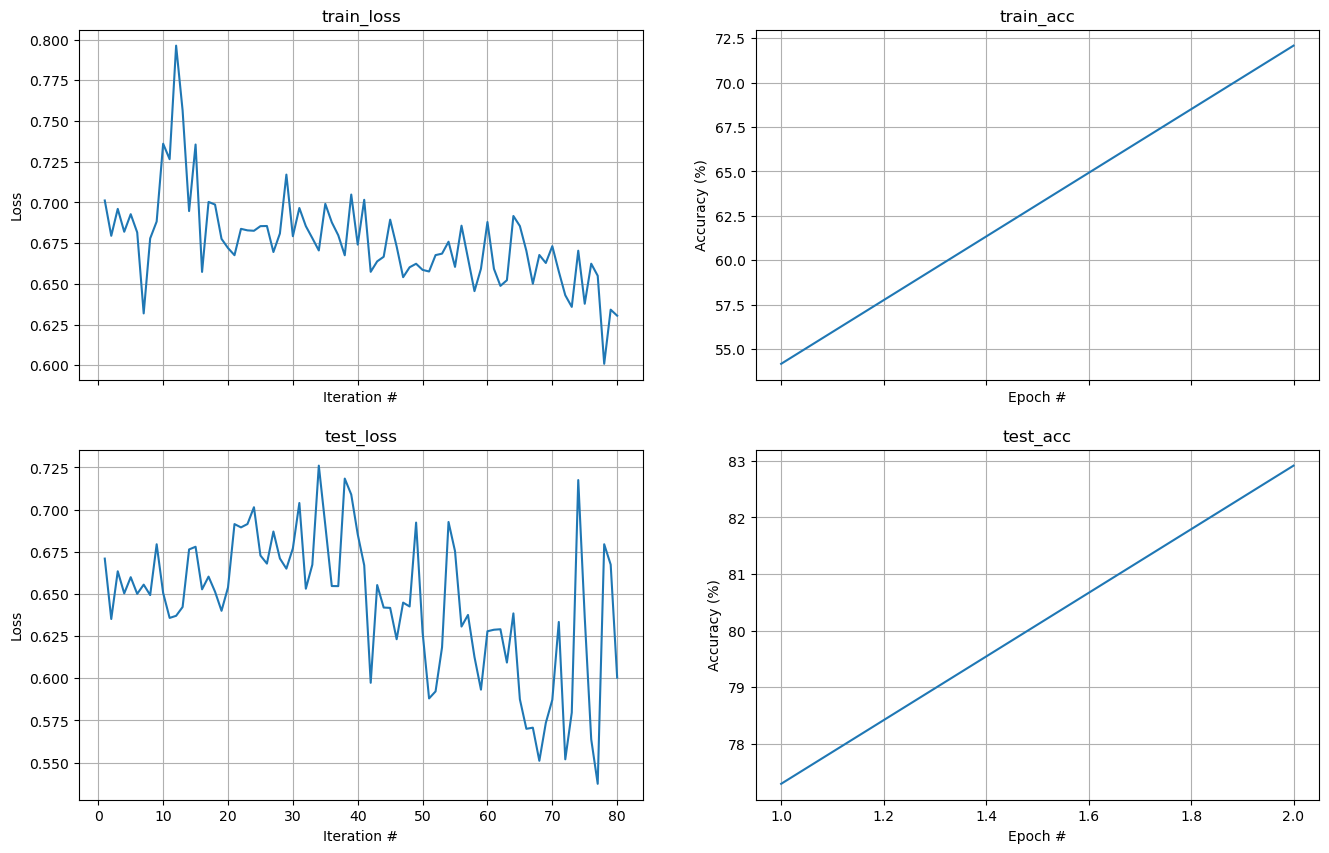

In [20]:
plot_fit(fit_result)

### Fine-tuning method 2 
__Retraining all the parameters in the model__

We will reload the model to ensure that the parameters are untouched and we are starting from scratch

In [21]:
from transformers import AutoModelForSequenceClassification


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
# TODO: Make sure all the model parameters are unfrozen
# ====== YOUR CODE: ======
for param in model.parameters():
    param.requires_grad = True
# ========================

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_all.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_all', num_epochs=2, max_batches= 40)
    with open('finetuned_all.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_all.pt')
model.load_state_dict(saved_state['model_state']) 

with open('finetuned_all.pkl', 'rb') as f:
    fit_result = pickle.load(f)  


--- EPOCH 1/2 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch (0.678):   0%|          | 0/40 [00:03<?, ?it/s]

train_batch (0.678):   2%|▎         | 1/40 [00:03<02:29,  3.84s/it]

train_batch (0.691):   2%|▎         | 1/40 [00:09<02:29,  3.84s/it]

train_batch (0.691):   5%|▌         | 2/40 [00:09<03:04,  4.85s/it]

train_batch (0.691):   5%|▌         | 2/40 [00:14<03:04,  4.85s/it]

train_batch (0.691):   8%|▊         | 3/40 [00:14<02:57,  4.80s/it]

train_batch (0.620):   8%|▊         | 3/40 [00:19<02:57,  4.80s/it]

train_batch (0.620):  10%|█         | 4/40 [00:19<02:54,  4.84s/it]

train_batch (0.802):  10%|█         | 4/40 [00:24<02:54,  4.84s/it]

train_batch (0.802):  12%|█▎        | 5/40 [00:24<02:51,  4.91s/it]

train_batch (0.743):  12%|█▎        | 5/40 [00:29<02:51,  4.91s/it]

train_batch (0.743):  15%|█▌        | 6/40 [00:29<02:50,  5.00s/it]

train_batch (0.682):  15%|█▌        | 6/40 [00:35<02:50,  5.00s/it]

train_batch (0.682):  18%|█▊        | 7/40 [00:35<02:54,  5.30s/it]

train_batch (0.652):  18%|█▊        | 7/40 [00:41<02:54,  5.30s/it]

train_batch (0.652):  20%|██        | 8/40 [00:41<02:56,  5.52s/it]

train_batch (0.713):  20%|██        | 8/40 [00:46<02:56,  5.52s/it]

train_batch (0.713):  22%|██▎       | 9/40 [00:46<02:45,  5.34s/it]

train_batch (0.605):  22%|██▎       | 9/40 [00:51<02:45,  5.34s/it]

train_batch (0.605):  25%|██▌       | 10/40 [00:51<02:37,  5.25s/it]

train_batch (0.545):  25%|██▌       | 10/40 [00:56<02:37,  5.25s/it]

train_batch (0.545):  28%|██▊       | 11/40 [00:56<02:29,  5.16s/it]

train_batch (0.770):  28%|██▊       | 11/40 [01:00<02:29,  5.16s/it]

train_batch (0.770):  30%|███       | 12/40 [01:00<02:21,  5.07s/it]

train_batch (0.723):  30%|███       | 12/40 [01:05<02:21,  5.07s/it]

train_batch (0.723):  32%|███▎      | 13/40 [01:05<02:15,  5.01s/it]

train_batch (0.657):  32%|███▎      | 13/40 [01:10<02:15,  5.01s/it]

train_batch (0.657):  35%|███▌      | 14/40 [01:10<02:08,  4.96s/it]

train_batch (0.589):  35%|███▌      | 14/40 [01:15<02:08,  4.96s/it]

train_batch (0.589):  38%|███▊      | 15/40 [01:15<02:02,  4.92s/it]

train_batch (0.558):  38%|███▊      | 15/40 [01:20<02:02,  4.92s/it]

train_batch (0.558):  40%|████      | 16/40 [01:20<01:57,  4.89s/it]

train_batch (0.533):  40%|████      | 16/40 [01:25<01:57,  4.89s/it]

train_batch (0.533):  42%|████▎     | 17/40 [01:25<01:52,  4.88s/it]

train_batch (0.596):  42%|████▎     | 17/40 [01:30<01:52,  4.88s/it]

train_batch (0.596):  45%|████▌     | 18/40 [01:30<01:47,  4.89s/it]

train_batch (0.511):  45%|████▌     | 18/40 [01:35<01:47,  4.89s/it]

train_batch (0.511):  48%|████▊     | 19/40 [01:35<01:43,  4.91s/it]

train_batch (0.435):  48%|████▊     | 19/40 [01:39<01:43,  4.91s/it]

train_batch (0.435):  50%|█████     | 20/40 [01:39<01:38,  4.92s/it]

train_batch (0.590):  50%|█████     | 20/40 [01:44<01:38,  4.92s/it]

train_batch (0.590):  52%|█████▎    | 21/40 [01:44<01:33,  4.93s/it]

train_batch (0.438):  52%|█████▎    | 21/40 [01:49<01:33,  4.93s/it]

train_batch (0.438):  55%|█████▌    | 22/40 [01:49<01:28,  4.94s/it]

train_batch (0.417):  55%|█████▌    | 22/40 [01:54<01:28,  4.94s/it]

train_batch (0.417):  57%|█████▊    | 23/40 [01:54<01:23,  4.94s/it]

train_batch (0.482):  57%|█████▊    | 23/40 [01:59<01:23,  4.94s/it]

train_batch (0.482):  60%|██████    | 24/40 [01:59<01:19,  4.94s/it]

train_batch (0.423):  60%|██████    | 24/40 [02:04<01:19,  4.94s/it]

train_batch (0.423):  62%|██████▎   | 25/40 [02:04<01:13,  4.92s/it]

train_batch (0.230):  62%|██████▎   | 25/40 [02:09<01:13,  4.92s/it]

train_batch (0.230):  65%|██████▌   | 26/40 [02:09<01:08,  4.93s/it]

train_batch (0.322):  65%|██████▌   | 26/40 [02:15<01:08,  4.93s/it]

train_batch (0.322):  68%|██████▊   | 27/40 [02:15<01:08,  5.25s/it]

train_batch (0.783):  68%|██████▊   | 27/40 [02:20<01:08,  5.25s/it]

train_batch (0.783):  70%|███████   | 28/40 [02:20<01:01,  5.15s/it]

train_batch (0.287):  70%|███████   | 28/40 [02:25<01:01,  5.15s/it]

train_batch (0.287):  72%|███████▎  | 29/40 [02:25<00:55,  5.08s/it]

train_batch (0.464):  72%|███████▎  | 29/40 [02:30<00:55,  5.08s/it]

train_batch (0.464):  75%|███████▌  | 30/40 [02:30<00:50,  5.01s/it]

train_batch (0.598):  75%|███████▌  | 30/40 [02:35<00:50,  5.01s/it]

train_batch (0.598):  78%|███████▊  | 31/40 [02:35<00:45,  5.01s/it]

train_batch (0.590):  78%|███████▊  | 31/40 [02:40<00:45,  5.01s/it]

train_batch (0.590):  80%|████████  | 32/40 [02:40<00:40,  5.02s/it]

train_batch (0.570):  80%|████████  | 32/40 [02:45<00:40,  5.02s/it]

train_batch (0.570):  82%|████████▎ | 33/40 [02:45<00:35,  5.02s/it]

train_batch (0.246):  82%|████████▎ | 33/40 [02:51<00:35,  5.02s/it]

train_batch (0.246):  85%|████████▌ | 34/40 [02:51<00:31,  5.28s/it]

train_batch (0.196):  85%|████████▌ | 34/40 [02:56<00:31,  5.28s/it]

train_batch (0.196):  88%|████████▊ | 35/40 [02:56<00:25,  5.16s/it]

train_batch (0.232):  88%|████████▊ | 35/40 [03:00<00:25,  5.16s/it]

train_batch (0.232):  90%|█████████ | 36/40 [03:00<00:20,  5.06s/it]

train_batch (0.424):  90%|█████████ | 36/40 [03:05<00:20,  5.06s/it]

train_batch (0.424):  92%|█████████▎| 37/40 [03:05<00:14,  4.98s/it]

train_batch (0.280):  92%|█████████▎| 37/40 [03:10<00:14,  4.98s/it]

train_batch (0.280):  95%|█████████▌| 38/40 [03:10<00:09,  4.95s/it]

train_batch (0.431):  95%|█████████▌| 38/40 [03:15<00:09,  4.95s/it]

train_batch (0.431):  98%|█████████▊| 39/40 [03:15<00:04,  4.91s/it]

train_batch (0.432):  98%|█████████▊| 39/40 [03:20<00:04,  4.91s/it]

train_batch (0.432): 100%|██████████| 40/40 [03:20<00:00,  4.89s/it]

train_batch (Avg. Loss 0.531, Accuracy 73.3): 100%|██████████| 40/40 [03:20<00:00,  4.89s/it]

train_batch (Avg. Loss 0.531, Accuracy 73.3): 100%|██████████| 40/40 [03:20<00:00,  5.01s/it]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.181):   0%|          | 0/40 [00:02<?, ?it/s]

test_batch (0.181):   2%|▎         | 1/40 [00:02<01:41,  2.60s/it]

test_batch (0.131):   2%|▎         | 1/40 [00:05<01:41,  2.60s/it]

test_batch (0.131):   5%|▌         | 2/40 [00:05<01:38,  2.59s/it]

test_batch (0.206):   5%|▌         | 2/40 [00:07<01:38,  2.59s/it]

test_batch (0.206):   8%|▊         | 3/40 [00:07<01:35,  2.59s/it]

test_batch (0.402):   8%|▊         | 3/40 [00:10<01:35,  2.59s/it]

test_batch (0.402):  10%|█         | 4/40 [00:10<01:33,  2.59s/it]

test_batch (0.241):  10%|█         | 4/40 [00:12<01:33,  2.59s/it]

test_batch (0.241):  12%|█▎        | 5/40 [00:12<01:30,  2.59s/it]

test_batch (0.251):  12%|█▎        | 5/40 [00:15<01:30,  2.59s/it]

test_batch (0.251):  15%|█▌        | 6/40 [00:15<01:27,  2.59s/it]

test_batch (0.137):  15%|█▌        | 6/40 [00:18<01:27,  2.59s/it]

test_batch (0.137):  18%|█▊        | 7/40 [00:18<01:25,  2.59s/it]

test_batch (0.413):  18%|█▊        | 7/40 [00:20<01:25,  2.59s/it]

test_batch (0.413):  20%|██        | 8/40 [00:20<01:22,  2.59s/it]

test_batch (0.362):  20%|██        | 8/40 [00:23<01:22,  2.59s/it]

test_batch (0.362):  22%|██▎       | 9/40 [00:23<01:20,  2.59s/it]

test_batch (0.168):  22%|██▎       | 9/40 [00:25<01:20,  2.59s/it]

test_batch (0.168):  25%|██▌       | 10/40 [00:25<01:17,  2.59s/it]

test_batch (0.110):  25%|██▌       | 10/40 [00:28<01:17,  2.59s/it]

test_batch (0.110):  28%|██▊       | 11/40 [00:28<01:15,  2.59s/it]

test_batch (0.119):  28%|██▊       | 11/40 [00:31<01:15,  2.59s/it]

test_batch (0.119):  30%|███       | 12/40 [00:31<01:12,  2.59s/it]

test_batch (0.138):  30%|███       | 12/40 [00:33<01:12,  2.59s/it]

test_batch (0.138):  32%|███▎      | 13/40 [00:33<01:09,  2.59s/it]

test_batch (0.251):  32%|███▎      | 13/40 [00:36<01:09,  2.59s/it]

test_batch (0.251):  35%|███▌      | 14/40 [00:36<01:07,  2.59s/it]

test_batch (0.170):  35%|███▌      | 14/40 [00:38<01:07,  2.59s/it]

test_batch (0.170):  38%|███▊      | 15/40 [00:38<01:04,  2.59s/it]

test_batch (0.320):  38%|███▊      | 15/40 [00:41<01:04,  2.59s/it]

test_batch (0.320):  40%|████      | 16/40 [00:41<01:02,  2.59s/it]

test_batch (0.308):  40%|████      | 16/40 [00:44<01:02,  2.59s/it]

test_batch (0.308):  42%|████▎     | 17/40 [00:44<00:59,  2.59s/it]

test_batch (0.133):  42%|████▎     | 17/40 [00:46<00:59,  2.59s/it]

test_batch (0.133):  45%|████▌     | 18/40 [00:46<00:56,  2.59s/it]

test_batch (0.126):  45%|████▌     | 18/40 [00:49<00:56,  2.59s/it]

test_batch (0.126):  48%|████▊     | 19/40 [00:49<00:54,  2.59s/it]

test_batch (0.166):  48%|████▊     | 19/40 [00:51<00:54,  2.59s/it]

test_batch (0.166):  50%|█████     | 20/40 [00:51<00:51,  2.59s/it]

test_batch (0.359):  50%|█████     | 20/40 [00:54<00:51,  2.59s/it]

test_batch (0.359):  52%|█████▎    | 21/40 [00:54<00:49,  2.59s/it]

test_batch (0.825):  52%|█████▎    | 21/40 [00:56<00:49,  2.59s/it]

test_batch (0.825):  55%|█████▌    | 22/40 [00:56<00:46,  2.59s/it]

test_batch (0.472):  55%|█████▌    | 22/40 [00:59<00:46,  2.59s/it]

test_batch (0.472):  57%|█████▊    | 23/40 [00:59<00:43,  2.58s/it]

test_batch (0.646):  57%|█████▊    | 23/40 [01:02<00:43,  2.58s/it]

test_batch (0.646):  60%|██████    | 24/40 [01:02<00:41,  2.58s/it]

test_batch (0.404):  60%|██████    | 24/40 [01:04<00:41,  2.58s/it]

test_batch (0.404):  62%|██████▎   | 25/40 [01:04<00:38,  2.58s/it]

test_batch (0.479):  62%|██████▎   | 25/40 [01:07<00:38,  2.58s/it]

test_batch (0.479):  65%|██████▌   | 26/40 [01:07<00:36,  2.58s/it]

test_batch (0.184):  65%|██████▌   | 26/40 [01:09<00:36,  2.58s/it]

test_batch (0.184):  68%|██████▊   | 27/40 [01:09<00:33,  2.59s/it]

test_batch (0.140):  68%|██████▊   | 27/40 [01:12<00:33,  2.59s/it]

test_batch (0.140):  70%|███████   | 28/40 [01:12<00:31,  2.59s/it]

test_batch (0.232):  70%|███████   | 28/40 [01:15<00:31,  2.59s/it]

test_batch (0.232):  72%|███████▎  | 29/40 [01:15<00:28,  2.59s/it]

test_batch (0.574):  72%|███████▎  | 29/40 [01:17<00:28,  2.59s/it]

test_batch (0.574):  75%|███████▌  | 30/40 [01:17<00:25,  2.59s/it]

test_batch (0.624):  75%|███████▌  | 30/40 [01:20<00:25,  2.59s/it]

test_batch (0.624):  78%|███████▊  | 31/40 [01:20<00:23,  2.59s/it]

test_batch (0.222):  78%|███████▊  | 31/40 [01:22<00:23,  2.59s/it]

test_batch (0.222):  80%|████████  | 32/40 [01:22<00:20,  2.61s/it]

test_batch (0.363):  80%|████████  | 32/40 [01:25<00:20,  2.61s/it]

test_batch (0.363):  82%|████████▎ | 33/40 [01:25<00:18,  2.62s/it]

test_batch (1.072):  82%|████████▎ | 33/40 [01:28<00:18,  2.62s/it]

test_batch (1.072):  85%|████████▌ | 34/40 [01:28<00:15,  2.62s/it]

test_batch (0.619):  85%|████████▌ | 34/40 [01:30<00:15,  2.62s/it]

test_batch (0.619):  88%|████████▊ | 35/40 [01:30<00:13,  2.64s/it]

test_batch (0.367):  88%|████████▊ | 35/40 [01:33<00:13,  2.64s/it]

test_batch (0.367):  90%|█████████ | 36/40 [01:33<00:10,  2.64s/it]

test_batch (0.278):  90%|█████████ | 36/40 [01:36<00:10,  2.64s/it]

test_batch (0.278):  92%|█████████▎| 37/40 [01:36<00:07,  2.63s/it]

test_batch (0.623):  92%|█████████▎| 37/40 [01:38<00:07,  2.63s/it]

test_batch (0.623):  95%|█████████▌| 38/40 [01:38<00:05,  2.64s/it]

test_batch (0.733):  95%|█████████▌| 38/40 [01:41<00:05,  2.64s/it]

test_batch (0.733):  98%|█████████▊| 39/40 [01:41<00:02,  2.64s/it]

test_batch (0.531):  98%|█████████▊| 39/40 [01:44<00:02,  2.64s/it]

test_batch (0.531): 100%|██████████| 40/40 [01:44<00:00,  2.65s/it]

test_batch (Avg. Loss 0.352, Accuracy 84.2): 100%|██████████| 40/40 [01:44<00:00,  2.65s/it]

test_batch (Avg. Loss 0.352, Accuracy 84.2): 100%|██████████| 40/40 [01:44<00:00,  2.60s/it]

*** Saved checkpoint finetuned_all.pt at epoch 1
--- EPOCH 2/2 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch (0.369):   0%|          | 0/40 [00:04<?, ?it/s]

train_batch (0.369):   2%|▎         | 1/40 [00:04<03:12,  4.94s/it]

train_batch (0.796):   2%|▎         | 1/40 [00:09<03:12,  4.94s/it]

train_batch (0.796):   5%|▌         | 2/40 [00:09<03:05,  4.89s/it]

train_batch (0.340):   5%|▌         | 2/40 [00:14<03:05,  4.89s/it]

train_batch (0.340):   8%|▊         | 3/40 [00:14<03:02,  4.94s/it]

train_batch (0.523):   8%|▊         | 3/40 [00:19<03:02,  4.94s/it]

train_batch (0.523):  10%|█         | 4/40 [00:19<02:58,  4.95s/it]

train_batch (0.424):  10%|█         | 4/40 [00:25<02:58,  4.95s/it]

train_batch (0.424):  12%|█▎        | 5/40 [00:25<03:05,  5.30s/it]

train_batch (0.342):  12%|█▎        | 5/40 [00:30<03:05,  5.30s/it]

train_batch (0.342):  15%|█▌        | 6/40 [00:30<02:55,  5.17s/it]

train_batch (0.253):  15%|█▌        | 6/40 [00:36<02:55,  5.17s/it]

train_batch (0.253):  18%|█▊        | 7/40 [00:36<02:59,  5.43s/it]

train_batch (0.405):  18%|█▊        | 7/40 [00:41<02:59,  5.43s/it]

train_batch (0.405):  20%|██        | 8/40 [00:41<02:48,  5.26s/it]

train_batch (0.268):  20%|██        | 8/40 [00:46<02:48,  5.26s/it]

train_batch (0.268):  22%|██▎       | 9/40 [00:46<02:38,  5.13s/it]

train_batch (0.600):  22%|██▎       | 9/40 [00:51<02:38,  5.13s/it]

train_batch (0.600):  25%|██▌       | 10/40 [00:51<02:31,  5.04s/it]

train_batch (0.338):  25%|██▌       | 10/40 [00:55<02:31,  5.04s/it]

train_batch (0.338):  28%|██▊       | 11/40 [00:55<02:24,  4.97s/it]

train_batch (0.445):  28%|██▊       | 11/40 [01:00<02:24,  4.97s/it]

train_batch (0.445):  30%|███       | 12/40 [01:00<02:17,  4.92s/it]

train_batch (0.210):  30%|███       | 12/40 [01:05<02:17,  4.92s/it]

train_batch (0.210):  32%|███▎      | 13/40 [01:05<02:12,  4.90s/it]

train_batch (0.507):  32%|███▎      | 13/40 [01:10<02:12,  4.90s/it]

train_batch (0.507):  35%|███▌      | 14/40 [01:10<02:06,  4.87s/it]

train_batch (0.260):  35%|███▌      | 14/40 [01:15<02:06,  4.87s/it]

train_batch (0.260):  38%|███▊      | 15/40 [01:15<02:01,  4.86s/it]

train_batch (0.718):  38%|███▊      | 15/40 [01:20<02:01,  4.86s/it]

train_batch (0.718):  40%|████      | 16/40 [01:20<01:56,  4.85s/it]

train_batch (0.248):  40%|████      | 16/40 [01:24<01:56,  4.85s/it]

train_batch (0.248):  42%|████▎     | 17/40 [01:24<01:51,  4.84s/it]

train_batch (0.231):  42%|████▎     | 17/40 [01:29<01:51,  4.84s/it]

train_batch (0.231):  45%|████▌     | 18/40 [01:29<01:46,  4.84s/it]

train_batch (0.328):  45%|████▌     | 18/40 [01:34<01:46,  4.84s/it]

train_batch (0.328):  48%|████▊     | 19/40 [01:34<01:41,  4.83s/it]

train_batch (0.192):  48%|████▊     | 19/40 [01:39<01:41,  4.83s/it]

train_batch (0.192):  50%|█████     | 20/40 [01:39<01:36,  4.83s/it]

train_batch (0.275):  50%|█████     | 20/40 [01:44<01:36,  4.83s/it]

train_batch (0.275):  52%|█████▎    | 21/40 [01:44<01:31,  4.83s/it]

train_batch (0.182):  52%|█████▎    | 21/40 [01:49<01:31,  4.83s/it]

train_batch (0.182):  55%|█████▌    | 22/40 [01:49<01:26,  4.83s/it]

train_batch (0.211):  55%|█████▌    | 22/40 [01:53<01:26,  4.83s/it]

train_batch (0.211):  57%|█████▊    | 23/40 [01:53<01:22,  4.83s/it]

train_batch (0.148):  57%|█████▊    | 23/40 [01:58<01:22,  4.83s/it]

train_batch (0.148):  60%|██████    | 24/40 [01:58<01:17,  4.83s/it]

train_batch (0.271):  60%|██████    | 24/40 [02:03<01:17,  4.83s/it]

train_batch (0.271):  62%|██████▎   | 25/40 [02:03<01:12,  4.82s/it]

train_batch (0.937):  62%|██████▎   | 25/40 [02:08<01:12,  4.82s/it]

train_batch (0.937):  65%|██████▌   | 26/40 [02:08<01:07,  4.82s/it]

train_batch (0.227):  65%|██████▌   | 26/40 [02:13<01:07,  4.82s/it]

train_batch (0.227):  68%|██████▊   | 27/40 [02:13<01:02,  4.82s/it]

train_batch (0.162):  68%|██████▊   | 27/40 [02:17<01:02,  4.82s/it]

train_batch (0.162):  70%|███████   | 28/40 [02:17<00:57,  4.82s/it]

train_batch (0.216):  70%|███████   | 28/40 [02:22<00:57,  4.82s/it]

train_batch (0.216):  72%|███████▎  | 29/40 [02:22<00:52,  4.82s/it]

train_batch (0.595):  72%|███████▎  | 29/40 [02:27<00:52,  4.82s/it]

train_batch (0.595):  75%|███████▌  | 30/40 [02:27<00:48,  4.83s/it]

train_batch (0.292):  75%|███████▌  | 30/40 [02:32<00:48,  4.83s/it]

train_batch (0.292):  78%|███████▊  | 31/40 [02:32<00:43,  4.83s/it]

train_batch (0.283):  78%|███████▊  | 31/40 [02:37<00:43,  4.83s/it]

train_batch (0.283):  80%|████████  | 32/40 [02:37<00:38,  4.82s/it]

train_batch (0.299):  80%|████████  | 32/40 [02:42<00:38,  4.82s/it]

train_batch (0.299):  82%|████████▎ | 33/40 [02:42<00:33,  4.82s/it]

train_batch (0.373):  82%|████████▎ | 33/40 [02:46<00:33,  4.82s/it]

train_batch (0.373):  85%|████████▌ | 34/40 [02:46<00:28,  4.82s/it]

train_batch (0.390):  85%|████████▌ | 34/40 [02:51<00:28,  4.82s/it]

train_batch (0.390):  88%|████████▊ | 35/40 [02:51<00:24,  4.86s/it]

train_batch (0.159):  88%|████████▊ | 35/40 [02:57<00:24,  4.86s/it]

train_batch (0.159):  90%|█████████ | 36/40 [02:57<00:20,  5.20s/it]

train_batch (0.283):  90%|█████████ | 36/40 [03:02<00:20,  5.20s/it]

train_batch (0.283):  92%|█████████▎| 37/40 [03:02<00:15,  5.18s/it]

train_batch (0.285):  92%|█████████▎| 37/40 [03:09<00:15,  5.18s/it]

train_batch (0.285):  95%|█████████▌| 38/40 [03:09<00:10,  5.45s/it]

train_batch (0.115):  95%|█████████▌| 38/40 [03:14<00:10,  5.45s/it]

train_batch (0.115):  98%|█████████▊| 39/40 [03:14<00:05,  5.35s/it]

train_batch (0.570):  98%|█████████▊| 39/40 [03:19<00:05,  5.35s/it]

train_batch (0.570): 100%|██████████| 40/40 [03:19<00:00,  5.24s/it]

train_batch (Avg. Loss 0.352, Accuracy 85.4): 100%|██████████| 40/40 [03:19<00:00,  5.24s/it]

train_batch (Avg. Loss 0.352, Accuracy 85.4): 100%|██████████| 40/40 [03:19<00:00,  4.98s/it]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch (0.248):   0%|          | 0/40 [00:02<?, ?it/s]

test_batch (0.248):   2%|▎         | 1/40 [00:02<01:43,  2.66s/it]

test_batch (0.056):   2%|▎         | 1/40 [00:05<01:43,  2.66s/it]

test_batch (0.056):   5%|▌         | 2/40 [00:05<01:41,  2.67s/it]

test_batch (0.085):   5%|▌         | 2/40 [00:07<01:41,  2.67s/it]

test_batch (0.085):   8%|▊         | 3/40 [00:07<01:37,  2.64s/it]

test_batch (0.355):   8%|▊         | 3/40 [00:10<01:37,  2.64s/it]

test_batch (0.355):  10%|█         | 4/40 [00:10<01:35,  2.64s/it]

test_batch (0.174):  10%|█         | 4/40 [00:13<01:35,  2.64s/it]

test_batch (0.174):  12%|█▎        | 5/40 [00:13<01:32,  2.64s/it]

test_batch (0.120):  12%|█▎        | 5/40 [00:15<01:32,  2.64s/it]

test_batch (0.120):  15%|█▌        | 6/40 [00:15<01:29,  2.64s/it]

test_batch (0.220):  15%|█▌        | 6/40 [00:19<01:29,  2.64s/it]

test_batch (0.220):  18%|█▊        | 7/40 [00:19<01:38,  2.97s/it]

test_batch (0.178):  18%|█▊        | 7/40 [00:23<01:38,  2.97s/it]

test_batch (0.178):  20%|██        | 8/40 [00:23<01:43,  3.23s/it]

test_batch (0.433):  20%|██        | 8/40 [00:25<01:43,  3.23s/it]

test_batch (0.433):  22%|██▎       | 9/40 [00:25<01:34,  3.06s/it]

test_batch (0.294):  22%|██▎       | 9/40 [00:28<01:34,  3.06s/it]

test_batch (0.294):  25%|██▌       | 10/40 [00:28<01:27,  2.93s/it]

test_batch (0.046):  25%|██▌       | 10/40 [00:31<01:27,  2.93s/it]

test_batch (0.046):  28%|██▊       | 11/40 [00:31<01:22,  2.85s/it]

test_batch (0.056):  28%|██▊       | 11/40 [00:33<01:22,  2.85s/it]

test_batch (0.056):  30%|███       | 12/40 [00:33<01:18,  2.79s/it]

test_batch (0.061):  30%|███       | 12/40 [00:36<01:18,  2.79s/it]

test_batch (0.061):  32%|███▎      | 13/40 [00:36<01:14,  2.75s/it]

test_batch (0.142):  32%|███▎      | 13/40 [00:39<01:14,  2.75s/it]

test_batch (0.142):  35%|███▌      | 14/40 [00:39<01:10,  2.72s/it]

test_batch (0.088):  35%|███▌      | 14/40 [00:41<01:10,  2.72s/it]

test_batch (0.088):  38%|███▊      | 15/40 [00:41<01:06,  2.68s/it]

test_batch (0.195):  38%|███▊      | 15/40 [00:44<01:06,  2.68s/it]

test_batch (0.195):  40%|████      | 16/40 [00:44<01:03,  2.65s/it]

test_batch (0.151):  40%|████      | 16/40 [00:46<01:03,  2.65s/it]

test_batch (0.151):  42%|████▎     | 17/40 [00:46<01:00,  2.63s/it]

test_batch (0.179):  42%|████▎     | 17/40 [00:49<01:00,  2.63s/it]

test_batch (0.179):  45%|████▌     | 18/40 [00:49<00:57,  2.62s/it]

test_batch (0.055):  45%|████▌     | 18/40 [00:52<00:57,  2.62s/it]

test_batch (0.055):  48%|████▊     | 19/40 [00:52<00:54,  2.60s/it]

test_batch (0.092):  48%|████▊     | 19/40 [00:54<00:54,  2.60s/it]

test_batch (0.092):  50%|█████     | 20/40 [00:54<00:51,  2.60s/it]

test_batch (0.123):  50%|█████     | 20/40 [00:57<00:51,  2.60s/it]

test_batch (0.123):  52%|█████▎    | 21/40 [00:57<00:49,  2.60s/it]

test_batch (0.542):  52%|█████▎    | 21/40 [00:59<00:49,  2.60s/it]

test_batch (0.542):  55%|█████▌    | 22/40 [00:59<00:46,  2.59s/it]

test_batch (0.633):  55%|█████▌    | 22/40 [01:02<00:46,  2.59s/it]

test_batch (0.633):  57%|█████▊    | 23/40 [01:02<00:44,  2.60s/it]

test_batch (0.816):  57%|█████▊    | 23/40 [01:05<00:44,  2.60s/it]

test_batch (0.816):  60%|██████    | 24/40 [01:05<00:41,  2.60s/it]

test_batch (0.243):  60%|██████    | 24/40 [01:07<00:41,  2.60s/it]

test_batch (0.243):  62%|██████▎   | 25/40 [01:07<00:38,  2.59s/it]

test_batch (0.184):  62%|██████▎   | 25/40 [01:10<00:38,  2.59s/it]

test_batch (0.184):  65%|██████▌   | 26/40 [01:10<00:36,  2.60s/it]

test_batch (0.268):  65%|██████▌   | 26/40 [01:12<00:36,  2.60s/it]

test_batch (0.268):  68%|██████▊   | 27/40 [01:12<00:33,  2.60s/it]

test_batch (0.037):  68%|██████▊   | 27/40 [01:15<00:33,  2.60s/it]

test_batch (0.037):  70%|███████   | 28/40 [01:15<00:31,  2.60s/it]

test_batch (0.307):  70%|███████   | 28/40 [01:18<00:31,  2.60s/it]

test_batch (0.307):  72%|███████▎  | 29/40 [01:18<00:28,  2.60s/it]

test_batch (0.795):  72%|███████▎  | 29/40 [01:20<00:28,  2.60s/it]

test_batch (0.795):  75%|███████▌  | 30/40 [01:20<00:25,  2.60s/it]

test_batch (0.875):  75%|███████▌  | 30/40 [01:23<00:25,  2.60s/it]

test_batch (0.875):  78%|███████▊  | 31/40 [01:23<00:23,  2.59s/it]

test_batch (0.129):  78%|███████▊  | 31/40 [01:25<00:23,  2.59s/it]

test_batch (0.129):  80%|████████  | 32/40 [01:25<00:20,  2.59s/it]

test_batch (0.348):  80%|████████  | 32/40 [01:28<00:20,  2.59s/it]

test_batch (0.348):  82%|████████▎ | 33/40 [01:28<00:18,  2.59s/it]

test_batch (1.493):  82%|████████▎ | 33/40 [01:31<00:18,  2.59s/it]

test_batch (1.493):  85%|████████▌ | 34/40 [01:31<00:15,  2.60s/it]

test_batch (0.902):  85%|████████▌ | 34/40 [01:33<00:15,  2.60s/it]

test_batch (0.902):  88%|████████▊ | 35/40 [01:33<00:12,  2.59s/it]

test_batch (0.137):  88%|████████▊ | 35/40 [01:36<00:12,  2.59s/it]

test_batch (0.137):  90%|█████████ | 36/40 [01:36<00:10,  2.59s/it]

test_batch (0.163):  90%|█████████ | 36/40 [01:38<00:10,  2.59s/it]

test_batch (0.163):  92%|█████████▎| 37/40 [01:38<00:07,  2.60s/it]

test_batch (1.053):  92%|█████████▎| 37/40 [01:41<00:07,  2.60s/it]

test_batch (1.053):  95%|█████████▌| 38/40 [01:41<00:05,  2.60s/it]

test_batch (1.198):  95%|█████████▌| 38/40 [01:44<00:05,  2.60s/it]

test_batch (1.198):  98%|█████████▊| 39/40 [01:44<00:02,  2.59s/it]

test_batch (0.818):  98%|█████████▊| 39/40 [01:46<00:02,  2.59s/it]

test_batch (0.818): 100%|██████████| 40/40 [01:46<00:00,  2.59s/it]

test_batch (Avg. Loss 0.357, Accuracy 82.9): 100%|██████████| 40/40 [01:46<00:00,  2.59s/it]

test_batch (Avg. Loss 0.357, Accuracy 82.9): 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]

/tmp/ipykernel_59193/156929915.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load('finetuned_all.pt')


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

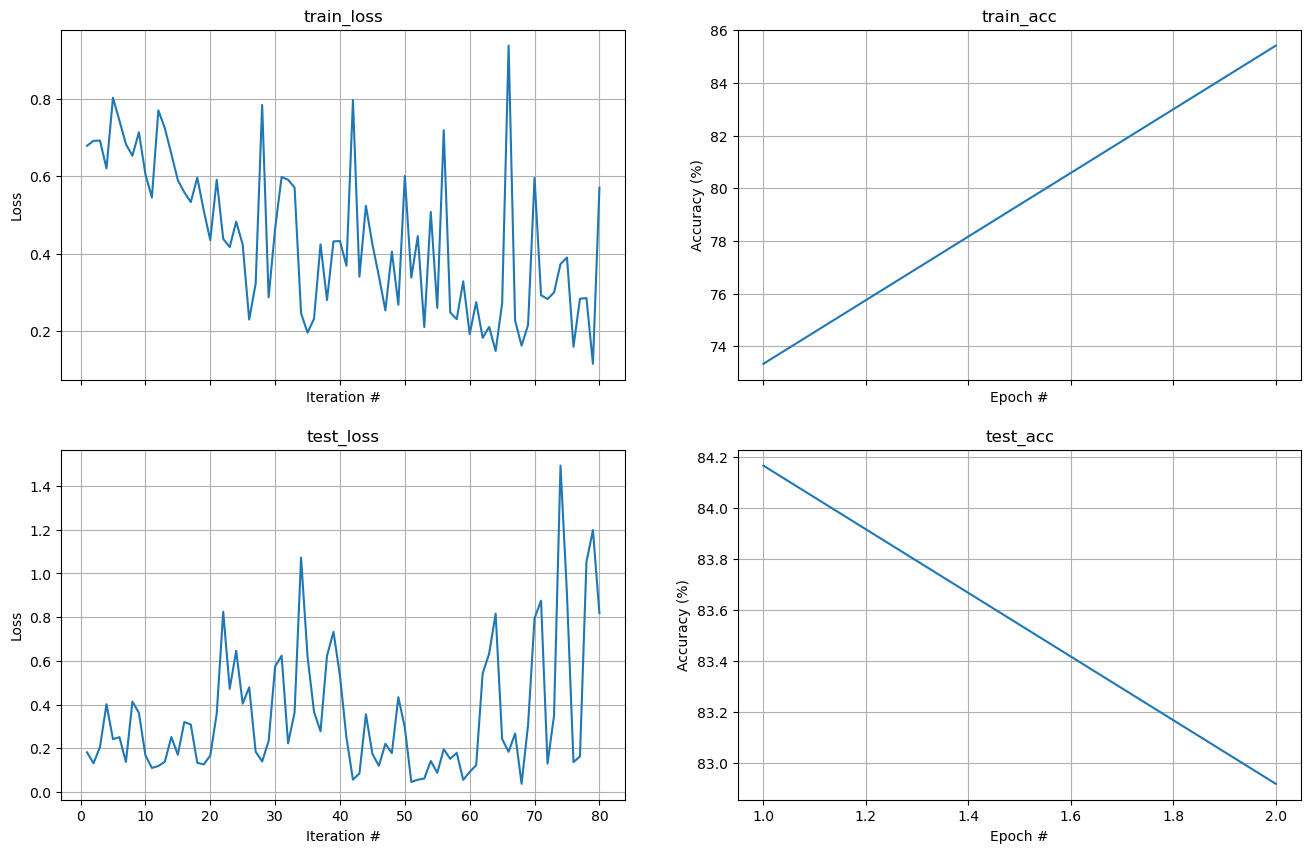

In [26]:
plot_fit(fit_result)

## Questions

Fill out your answers in `hw3.answers.part4_q1` and `hw3.answers.part4_q2`

In [27]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain the results that you got here in comparison to the results achieved in the *trained from scratch* encoder from the preivous part.  
If one of the models performed better, why was this so?   
Will this always be the case on any downstream task, or was this phenomenom specific to this task?


In [28]:
display_answer(hw3.answers.part4_q1)


Compared to the model from part 3, which achieved 65% accuracy, this model is far better, with over 85% accuracy in both methods of fine-tuning. This model is more robust, was pre-trained on a larger data set, and was trained by someone with more experience than an undergrad student. It was also fine-tuned to get better results.
It cannot be garunteed that for every downstream task the fine-tuned model would perform better, as there might be a task which has unusual nature, which contradicts many assumptions the pre-trained model was trained to learn. For example, learning to classify if an IMDB review is positive/negative when the review is written with many grammer mistakes and unusual writing. 
A model trained to handle unusual language and sentence pattern would probably be better at recognizing the patterns in this task and might perform better if trained from scratch.


### Question 2

Assume that when fine-tuning, instead of freezing the internal model layers and leaving the last 2 layers unfrozen, we instead froze the last layers and fine-tuned internal layers such as the multi-headed attention block .
Would the model still be able to succesfully fine-tune to this task?   
Or would the results be worse?  
Explain  

In [29]:
display_answer(hw3.answers.part4_q2)


The model would not be able to fine-tune using this method. In pre-trained language models, the last layers are typically responsible for generating high-level, task-specific representations. Freezing these layers means that these representations remain fixed, and any updates made to the internal layers may not effectively align with the specific task.


### Question 3

If you want to conduct a machine translation task, as seen in the tutorials, can you use BERT?

Describe the modulation you need to do, i.e. if the source tokens are $x_t$ and the target are $y_t$, how would the model work to produce the translation?

If the model can't handle this task, describe the architecture changes and why you need them. If a change in the pre-training is required, describe it as well.

In [30]:
display_answer(hw3.answers.part4_q3)


Since BERT is an encoder only model, and machine translation requires encoder-decoder (for proccessing input text and generating output text), BERT cannot be used for translation tasks. The changes needed inorder to make it up to the task, is to add a decoder to the architecture in the following way:
The x_t input would be encoded into latent space using BERT, the output of BERT would be fed into a decoder which its output will be compared with y_t to compute the loss, using some chosen optimizer the weights of the BERT and the DECODER would be updated to learn the task of translation.
The BERT can also be pre-trained beforehand and only fine-tuned during the translation training. 


### Question 4

We saw in the course two types on sequntial modeling: RNN and Transformers.

What could be the main reason to choose RNN over a Transformer? Note that both can be light weight or heavy in computation.

In [31]:
display_answer(hw3.answers.part4_q4)


The main reason to choose RNN over a transformer is its ability to Handle Long Sequences with Limited Resources.
RNNs process sequences sequentially, meaning they don’t require storing or computing pairwise attention over the entire input sequence like Transformers do. For tasks where you need to handle very long sequences with limited memory, RNNs can be more efficient since they only store hidden states across time steps rather than full attention matrices. This can be advantageous when computational resources are constrained.


### Question 5

We have learned that BERT uses "Next Sentence Prediction" (NSP) as part of the pre-training tasks.

Describe what it is (where is the prediction accure, what is the loss).

Do you think this is a crucial part of pre-training? try to analize why you gave the answer, i.e. what essensity it gives to the model, or why it's implicitly don't contibute much. 


In [32]:
display_answer(hw3.answers.part4_q5)


NSP trains the model to determine whether or not two sentences are immidiately connected in a text, meaning one comes right after the other. Loss comes from the predicted certainty of both options. the more certain the model is of the correct answer (connected/not connected), the lower the loss is.
Next Sentence Prediction is a crucial part of pre-training, because it provides context for entire sentences, and not only words.
